## Import Library

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset, load_metric
from tqdm import tqdm
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import random
import spacy
import re
import unicodedata
from collections import Counter
import pandas as pd
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np

c:\Users\solit\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Transformer Model

### Scale Dot Product Attention

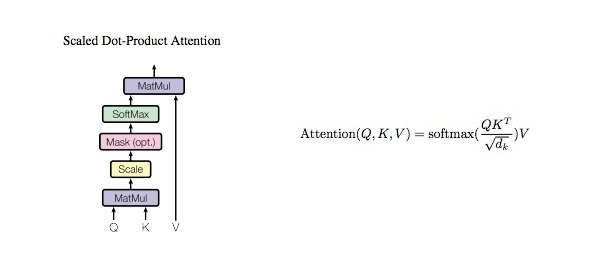

In [2]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, query, key, value, mask=None):
        d_k = query.size(-1)
        scores = torch.matmul(query, key.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attention = F.softmax(scores, dim=-1)
        return torch.matmul(attention, value), attention


### Multi-Head Attention

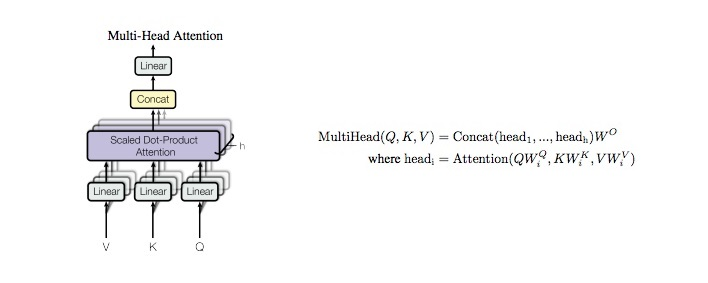

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()

        assert d_model % num_heads == 0

        self.num_heads = num_heads
        self.d_model = d_model
        self.d_k = d_model // num_heads

        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.out = nn.Linear(d_model, d_model)

        self.attention = ScaledDotProductAttention()


    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        query = self.query(query).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        key = self.key(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        value = self.value(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        out, _ = self.attention(query, key, value, mask)
        out = out.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)

        return self.out(out)

### Feed-Forward Neural Network

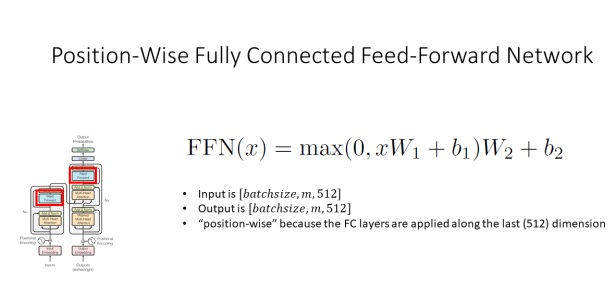

In [4]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(FeedForward, self).__init__()

        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.linear2(self.dropout(F.relu(self.linear1(x))))

### Positional Encoding

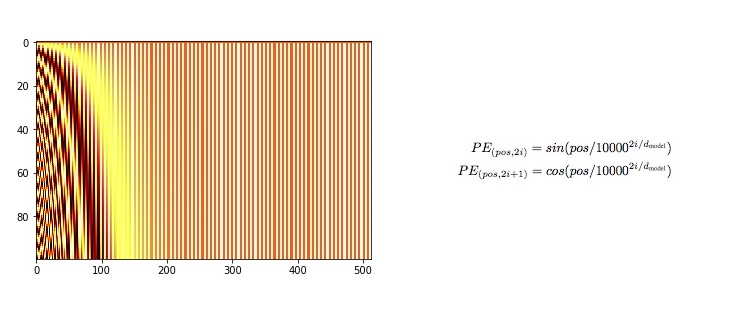

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()

        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        return x + self.encoding[:, :x.size(1)].to(x.device)

### Encoder and Decoder

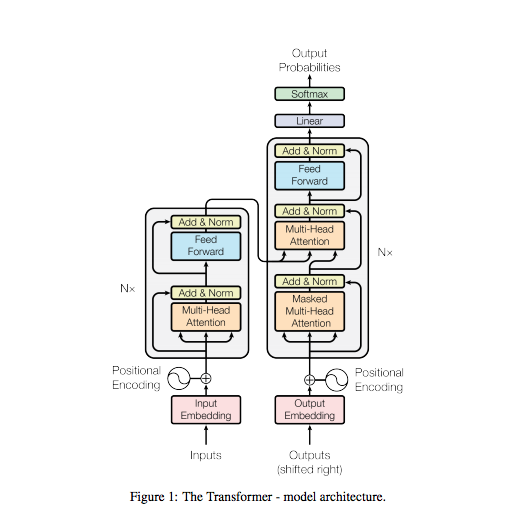

In [6]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, drop_out=0.1):
        super(EncoderLayer, self).__init__()

        self.self_attention = MultiHeadAttention(d_model, num_heads)
        self.ffn = FeedForward(d_model, d_ff, drop_out)
        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(drop_out)

    def forward(self, x, mask):
        attention_out = self.self_attention(x, x, x, mask)
        x = self.layernorm1(x + self.dropout(attention_out))
        ffn_out = self.ffn(x)
        x = self.layernorm2(x + self.dropout(ffn_out))
        return x


In [7]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, drop_out=0.1):
        super(DecoderLayer, self).__init__()

        self.masked_self_attention = MultiHeadAttention(d_model, num_heads)
        self.self_attention = MultiHeadAttention(d_model, num_heads)
        self.ffn = FeedForward(d_model, d_ff, drop_out)

        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)
        self.layernorm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(drop_out)

    def forward(self, x, encoder_out, target_mask, attention_mask):
        masked_self_attention_out = self.masked_self_attention(x, x, x, target_mask)
        x = self.layernorm1(x + self.dropout(masked_self_attention_out))

        self_attention_out = self.self_attention(x, encoder_out, encoder_out, attention_mask)
        x = self.layernorm2(x + self.dropout(self_attention_out))

        ffn_output = self.ffn(x)
        x = self.layernorm3(x + self.dropout(ffn_output))

        return x

### Model

In [8]:
class TransFormerModel(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_encoder_layers, num_decoder_layers, d_ff, drop_out=0.1, max_len=5000):
        super(TransFormerModel, self).__init__()

        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, drop_out) for _ in range(num_encoder_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, drop_out) for _ in range(num_decoder_layers)])

        self.fc_out = nn.Linear(d_model, tgt_vocab_size)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)

        tgt_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, tgt_length, tgt_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask.to(tgt.device)
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src = self.encoder_embedding(src)
        src = self.positional_encoding(src)
        for layer in self.encoder_layers:
            src = layer(src, src_mask)

        tgt = self.decoder_embedding(tgt)
        tgt = self.positional_encoding(tgt)

        for layer in self.decoder_layers:
            tgt = layer(tgt, src, tgt_mask, src_mask)

        output = self.fc_out(tgt)
        return output

## Prepare data

In [9]:
dataset = load_dataset("Helsinki-NLP/opus-100", 'en-fr')

In [10]:
dataset['train'][0]

{'translation': {'en': 'The time now is 05:08 .',
  'fr': 'The time now is 05:05 .'}}

In [11]:
print(f'{len(dataset['train'])} , {len(dataset['validation'])} , {len(dataset['test'])}')

1000000 , 2000 , 2000


In [12]:
train_list = list(dataset['train'])

random_train = random.sample(train_list, 150000)

In [13]:
train_data_df = pd.DataFrame([item['translation'] for item in random_train])
valid_data_df = pd.DataFrame([item['translation'] for item in dataset['validation']])
test_data_df = pd.DataFrame([item['translation'] for item in dataset['test']])

In [14]:
# filepath = './data_150k_30/'
# train_data_df.to_csv(filepath + 'train.csv', index=False)
# valid_data_df.to_csv(filepath + 'valid.csv', index=False)
# test_data_df.to_csv(filepath + 'test.csv', index=False)

In [15]:
train_data_df = pd.read_csv('./data_150k_30/train.csv')
valid_data_df = pd.read_csv('./data_150k_30/valid.csv')
test_data_df = pd.read_csv('./data_150k_30/test.csv')
train_data_df

,en,fr
0,"For an excellent resource, see the Ministry of...","Pour plus de détails, consultez le Ministère d..."
1,I have my books.,J'ai mes livres.
2,- What's that around your neck?,- T'as quoi autour du cou?
3,Are you lost?,Vous êtes perdu ?
4,"Dane, honestly!",Vraiment !
...,...,...
149995,REASONS FOR OPENING THE PROCEDURE UNDER ARTICL...,MOTIFS DE L'OUVERTURE DE LA PROCÉDURE PRÉVUE À...
149996,"Well, after all...",après tout...
149997,Faux is a commune in the Dordogne department i...,Faux est une commune française située dans le ...
149998,The Commission monitored the experimen­tal pro...,La Commission a donne un suivi concret au proj...


In [16]:
class Vocabulary:
    def __init__(self, freq_threshold=2, language='en', preprocessor=None, reverse=False):
        self.itos = {0: "<pad>", 1: "<sos>", 2: "<eos>", 3: "<unk>"}
        self.stoi = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3}
        self.tokenizer = spacy.load(language)
        self.freq_threshold = freq_threshold
        self.preprocessor = preprocessor
        self.reverse = reverse

    def __len__(self):
        return len(self.itos)

    def tokenize(self, text):
        if self.reverse:
            return [token.text.lower() for token in self.tokenizer.tokenizer(text)][::-1]
        else:
            return [token.text.lower() for token in self.tokenizer.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = len(self.itos)

        for sentence in tqdm(sentence_list):
            # Preprocess the sentence using given preprocessor.
            if self.preprocessor:
                sentence = self.preprocessor(sentence)

            for word in self.tokenize(sentence):
                if word in frequencies:
                    frequencies[word] += 1
                else:
                    frequencies[word] = 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenize(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<unk>"]
            for token in tokenized_text
        ]

In [17]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.strip()
    return w

In [18]:
freq_threshold = 2
en_vocab = Vocabulary(freq_threshold=freq_threshold, language="en_core_web_sm", preprocessor=preprocess_sentence, reverse=False)
fr_vocab = Vocabulary(freq_threshold=freq_threshold, language="fr_core_news_sm", preprocessor=preprocess_sentence, reverse=False)

# build vocab for both english and german
en_vocab.build_vocabulary(train_data_df["en"].tolist())
fr_vocab.build_vocabulary(train_data_df["fr"].tolist())

100%|██████████| 150000/150000 [00:18<00:00, 8187.90it/s]


In [19]:
import torch
from torch.utils.data import Dataset

class CustomTranslationDataset(Dataset):    
    def __init__(self, df, fr_vocab, en_vocab, max_length=64):
        super().__init__()
        self.df = df
        self.en_vocab = en_vocab
        self.fr_vocab = fr_vocab
        self.max_length = max_length
        
    def __len__(self):
        return len(self.df)
    
    def _get_numericalized(self, sentence, vocab):
        """Numericalize given text using prebuilt vocab."""
        numericalized = [vocab.stoi["<sos>"]]
        numericalized.extend(vocab.numericalize(sentence))
        numericalized.append(vocab.stoi["<eos>"])
        return numericalized
    
    def _pad_sequence(self, sequence, pad_token_id):
        """Pad sequence to max_length."""
        if len(sequence) < self.max_length:
            sequence.extend([pad_token_id] * (self.max_length - len(sequence)))
        else:
            sequence = sequence[:self.max_length]
        return sequence
    
    def __getitem__(self, index):
        en_sentence = self.df.iloc[index]["en"]
        fr_sentence = self.df.iloc[index]["fr"]
        
        en_numericalized = self._get_numericalized(en_sentence, self.en_vocab)
        fr_numericalized = self._get_numericalized(fr_sentence, self.fr_vocab)
        
        # Apply padding
        en_padded = self._pad_sequence(en_numericalized, self.en_vocab.stoi["<pad>"])
        fr_padded = self._pad_sequence(fr_numericalized, self.fr_vocab.stoi["<pad>"])
        
        return torch.tensor(fr_padded, dtype=torch.long), torch.tensor(en_padded, dtype=torch.long)

In [20]:
train_dataset = CustomTranslationDataset(train_data_df, fr_vocab, en_vocab)
val_dataset = CustomTranslationDataset(valid_data_df, fr_vocab, en_vocab)
test_dataset = CustomTranslationDataset(test_data_df, fr_vocab, en_vocab)

In [21]:
train_dataset[0]

(tensor([   1,   38,   22,    4,    3,    8, 6177,   12,    3,    4,   91, 1090,
            5,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0]),
 tensor([   1,   25,   61, 1212, 3094,    6,  206,   10,  455,   14,  276,   82,
            4,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0]))

## Config

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [23]:
en_vocab_size = len(en_vocab)
fr_vocab_size = len(fr_vocab)
d_model = 256
num_heads = 8
num_encoder_layers = 6
num_decoder_layers = 6
d_ff = 512
drop_out = 0.1
batch_size = 32
num_epochs = 30

In [24]:
print(en_vocab_size) #100k: 27514 | 150k: 34254
print(fr_vocab_size) #100k: 32943 | 150k: 40843

34254
40843


In [25]:
model = TransFormerModel(fr_vocab_size, en_vocab_size, d_model, num_heads, num_encoder_layers, num_decoder_layers, d_ff, drop_out).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
metric = load_metric('bleu')

C:\Users\solit\AppData\Local\Temp\ipykernel_24036\1958691073.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('bleu')
c:\Users\solit\anaconda3\Lib\site-packages\datasets\load.py:759: FutureWarning: The repository for bleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/bleu/bleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [26]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Train, evaluate

In [27]:
def train(model, train_loader, src_vocab, tgt_vocab, criterion, optimizer, device, num_epochs=100):
    model.train()
    for epoch in tqdm(range(num_epochs)):
        running_loss = 0
        i = 0
        for src, tgt in train_loader:
            i += 1
            print(i,'/', len(train_loader))
            src, tgt = src.to(device), tgt.to(device)
            optimizer.zero_grad()
            output = model(src, tgt[:, :-1])
            loss = criterion(output.contiguous().view(-1, output.size(-1)), tgt[:, 1:].contiguous().view(-1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/100:.4f}')

    checkpoint = {
        "model_state_dict": model.state_dict(),
        "src_vocab": src_vocab,
        "tgt_vocab": tgt_vocab
    }
    torch.save(checkpoint, './checkpoint/transformer_model.pth')

In [28]:
def translate_sentence(model, sentence_df, src_vocab, tgt_vocab, device, is_print=True, max_length=64):
    model.eval()
    data = CustomTranslationDataset(sentence_df, src_vocab, tgt_vocab)
    src_tensor = data[0][0].unsqueeze(0).to(device)
    src_mask = model.generate_mask(src_tensor, src_tensor)[0]

    with torch.no_grad():
        enc_src = model.encoder_embedding(src_tensor)
        enc_src = model.positional_encoding(enc_src)
        for layer in model.encoder_layers:
            enc_src = layer(enc_src, src_mask)

    tgt_indexes = [tgt_vocab.stoi["<sos>"]]
    tgt_targets = data[0][1].unsqueeze(0).to(device) 
    total_loss = 0.0

    for idx in range(max_length):
        tgt_tensor = torch.tensor(tgt_indexes).unsqueeze(0).to(device)
        src_mask, tgt_mask = model.generate_mask(src_tensor, tgt_tensor)

        with torch.no_grad():
            dec_input = model.decoder_embedding(tgt_tensor)
            dec_input = model.positional_encoding(dec_input)
            for layer in model.decoder_layers:
                dec_input = layer(dec_input, enc_src, tgt_mask, src_mask)

        output = model.fc_out(dec_input)
        pred_token = output.argmax(2)[:, -1].item() 
        
        tgt_indexes.append(pred_token)

        if idx > 0 and idx < tgt_targets.size(1):  
            next_target = tgt_targets[:, idx]
            loss = criterion(output[:, -1, :], next_target)  
            total_loss += loss.item()

        if pred_token == tgt_vocab.stoi["<eos>"]:
            break

    translated_sentence = [tgt_vocab.itos[idx] for idx in tgt_indexes]
    predict_translate = " ".join(translated_sentence[1:-1])
    actual_sentences = sentence_df.iloc[0]['en'].lower()
    smoothing = SmoothingFunction().method4
    bleu_score = sentence_bleu(actual_sentences, predict_translate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing)

    if is_print:
        print('Sentences:', sentence_df.iloc[0]['fr'])
        print(f'Predict_translate: {predict_translate}') 
        print(f'Actual_sentences: {actual_sentences}', )
        print(f"Bleu score: {bleu_score}")
        print(f"Loss: {total_loss}")

    return bleu_score, total_loss


In [29]:
def evaluate_bleu(model, test_data_df, src_vocab, tgt_vocab, device, max_length=64):
    model.eval()
    
    bleu_scores = []
    losses = []

    for idx in tqdm(range(len(test_data_df))):
        data = pd.DataFrame(test_data_df.iloc[idx]).T
        score, loss = translate_sentence(model, data, src_vocab, tgt_vocab, device, is_print=False)
        bleu_scores.append(score)
        losses.append(loss)

    losses = [ls for ls in losses if not math.isnan(ls)]
    print(len(losses))
    
    avg_bleu_score = sum(bleu_scores) / len(bleu_scores)
    avg_loss = sum(losses) / len(losses)
    print(f"Average BLEU Score: {avg_bleu_score}")
    print(f"Average loss: {avg_loss}")

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    axes[0].boxplot(losses)
    axes[0].set_title('Boxplot of Losses')
    axes[0].set_ylabel('Loss Value')

    axes[1].boxplot(bleu_scores)
    axes[1].set_title('Boxplot of BLEU Scores')
    axes[1].set_ylabel('BLEU Score')

    plt.tight_layout()
    plt.show()
 
    return avg_bleu_score, avg_loss


### Train

In [ ]:
train(model, train_loader, fr_vocab, en_vocab, criterion, optimizer, device, num_epochs)

100%|██████████| 2000/2000 [09:40<00:00,  3.45it/s]


1421
Average BLEU Score: 0.011055152670559079
Average loss: 146.8085761644138


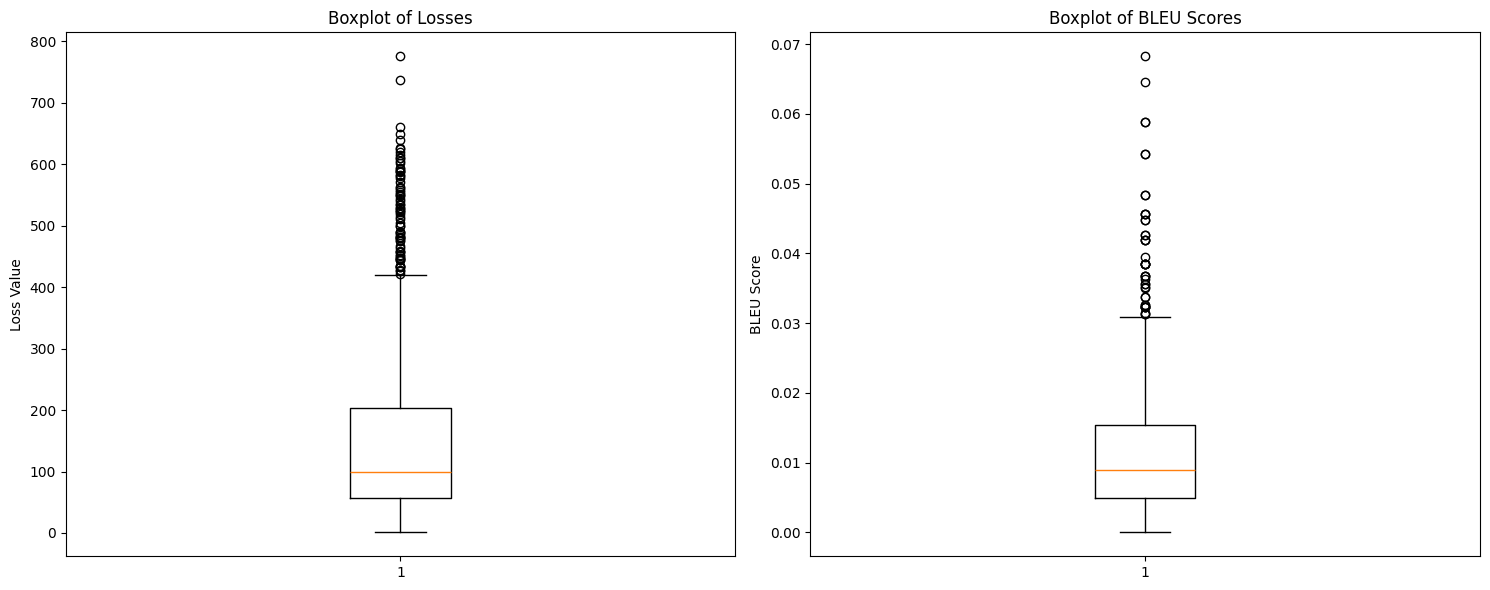

(0.011055152670559079, 146.8085761644138)

In [87]:
evaluate_bleu(model, test_data_df, fr_vocab, en_vocab, device)

## Test translate

In [30]:
checkpoint = torch.load('./checkpoint/transformer_model_150k_30.pth', map_location=device)
fr_vocab_test = checkpoint['src_vocab']
en_vocab_test = checkpoint['tgt_vocab']

In [31]:
test_translate_model = TransFormerModel(len(fr_vocab_test), len(en_vocab_test), d_model, num_heads, num_encoder_layers, num_decoder_layers, d_ff, drop_out)
test_translate_model.load_state_dict(checkpoint['model_state_dict'])
test_translate_model.to(device)

random_array = np.random.randint(0, 2000, size=20)

for idx in range(80, 120):
    test_translate_df = pd.DataFrame(test_data_df.iloc[idx]).T
    translate_sentence(test_translate_model, test_translate_df, fr_vocab_test, en_vocab_test, device)
    print('-' * 90)

Sentences: Cette conclusion a été confirmée par des registres visuels du site obtenus à l'aide d'engins télécommandés dans le cadre de levés antérieurs.
Predict_translate: this conclusion was observed by visual data from the site of the register of saint <unk> germain by inappropriate in the context of the market .
Actual_sentences: this has been confirmed by visual records of the site on previous surveys using rovs.
Bleu score: 0.005349174089232483
Loss: nan
------------------------------------------------------------------------------------------
Sentences: J'ai l'impression que ma queue est trop petite pour toi.
Predict_translate: i feel like my dick is too small for you .
Actual_sentences: i feel like my cock isn't big enough for you.
Bleu score: 0.013816930225553754
Loss: 131.70426607131958
------------------------------------------------------------------------------------------
Sentences: "Violette, à mes yeux s'effacer ton printemps
Predict_translate: <unk> <unk> , my eyes <unk

In [32]:
test_sentences = pd.DataFrame([{ "en": "- So why do people get so scared?", "fr": "Alors, pourquoi les gens ont si peur?" }])
translate_sentence(test_translate_model, test_sentences, fr_vocab_test, en_vocab_test, device)

Sentences: Alors, pourquoi les gens ont si peur?
Predict_translate: so why are people so scared ?
Actual_sentences: - so why do people get so scared?
Bleu score: 0.018503214404919213
Loss: 72.12530946731567


(0.018503214404919213, 72.12530946731567)